/home/eternal/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


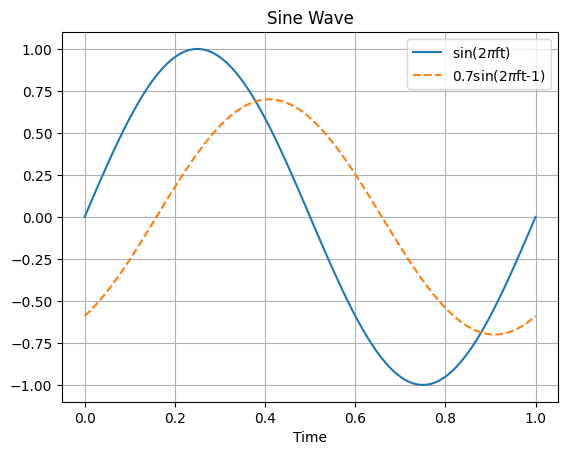

In [9]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0,1,100)
f = 1 #1Hz

plt.plot(t, 1 * np.sin(2*np.pi*f*t + 0), "-", 
         label='sin(2$\pi$ft)')
plt.plot(t, 0.7 * np.sin(2*np.pi*f*t - 1), ls="--", 
         label='0.7sin(2$\pi$ft-1)')

plt.xlabel("Time")
plt.title("Sine Wave")
plt.legend();plt.grid();plt.show()


In [24]:
def fade_io(data, length = 1000):
    # 0에서 1까지 선형적으로 증가하는 값 생성
    fade_in_data = np.linspace(0, 1, length)
    # Fade-in 적용
    data[:length] *= fade_in_data
    # 1에서 0까지 선형적으로 감소하는 값 생성
    fade_out_data = np.linspace(1, 0, length)
    # Fade-out 적용
    data[-length:] *= fade_out_data
    return data

#주파수와 실행시간을 인자로 받는 Sine 톤 함수 만들기
def sine_tone(f, duration=0.08, n=1280):
  t = np.linspace(0, duration, n)#fs = 1280/0.08 = 16kHz
  data = np.sin(2*np.pi*f*t)
  length = 10**int(np.log10(duration*n))
  return fade_io(data = data, length = length)
from IPython.display import Audio
Audio(sine_tone(300), rate=16000)


In [55]:
from IPython.display import Audio

fs=16000
scale=[440*2**(i/12)for i in range(10)] #몇번음까지 올릴건가
scale_tone=np.hstack([sine_tone(f)for f in scale])
Audio(scale_tone,rate=fs)

#440 Hz에 반음 12개를 올라간 2의 12/12 거듭제곱(즉, 2배)을 곱한 880 Hz가 됩니다.

In [56]:
octave=[440*(i+1)for i in range(10)]
octave_tone=np.hstack([sine_tone(f)for f in octave])
Audio(octave_tone,rate=fs)

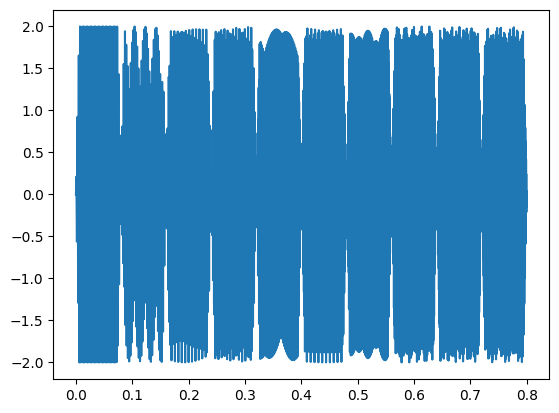

In [57]:
two_tone=np.add(scale_tone,octave_tone)

import matplotlib.pyplot as mp
mp.plot(np.linspace(0,len(two_tone)/fs,len(two_tone)),two_tone)
mp.show()
print()

Audio(two_tone, rate = fs)



In [61]:
from scipy.fftpack import fft
class me(Exception):
    pass

def n_fft(data,n_lim=20):     #n_fft(data, n_lim=20)은 입력 데이터의 길이를 확인하고 데이터의 길이 이상인 2의 제곱수 중 가장 작은 값을 반환합니다.
    for n in 2**np.arange(n_lim):
        if n>=len(data):
            return n
        if len(data)>2**(n_lim-1):
            return me(f"increase 'n_lim' by more than '{n_lim}'!!")

data=two_tone

try:
    N=n_fft(data)
    print(f"data' {len(data)}', number for FFT '{N}'")
except me as e:
    print(e)

fs = 16000
Y = fft(data,N)#np.fft.fft(data, N)    

data' 12800', number for FFT '16384'


(400.0, 2300.0)

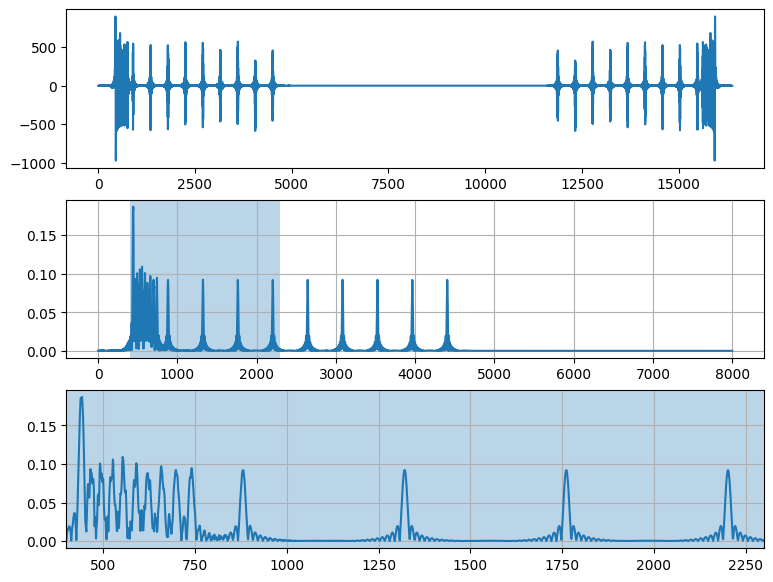

In [69]:
mp.figure(figsize=(9,7))
mp.subplot(311)
mp.plot(np.arange(len(Y)),Y)
mp.grid

mp.subplot(312)
mp.plot(np.linspace(0,fs/2,N//2),2*np.abs(Y[:N//2])/len(data))
mp.grid()
mp.axvspan(400,2300,alpha=0.3)

mp.subplot(313)
mp.plot(np.linspace(0,fs/2,N//2),2*np.abs(Y[:N//2])/len(data))
mp.grid()
mp.axvspan(400,2300,alpha=0.3)
mp.xlim(400,2300)

In [107]:
#MFCC구현
import librosa
import scipy
import seaborn as sns
import scipy.fftpack as fft

data=two_tone
n_fft=2048
hop=n_fft//4
# STFT 계산(출력차원: (n_fft//2) + 1 , T ) =(1025,13)
# T = (L - n_fft) // hop_length + 1(=구간개수=13)

stft = librosa.stft(data, n_fft=n_fft, window='hann', hop_length=hop, center=True)
print(stft.shape)


# Mel Filter Bank 계수 계산
mel_f=librosa.filters.mel(sr=fs,n_fft=n_fft,n_mels=128)
print(mel_f.shape)

power_spec=np.abs(stft)

mel_spec=np.dot(mel_f,power_spec)

log_mel_spec=20*np.log10(mel_spec)
print(log_mel_spec.shape)

n_mfcc=20
mfcc=fft.dct(log_mel_spec,axis=0,norm='ortho')[:n_mfcc]
print(mfcc.shape)

(1025, 26)
(128, 1025)
(128, 26)
(20, 26)


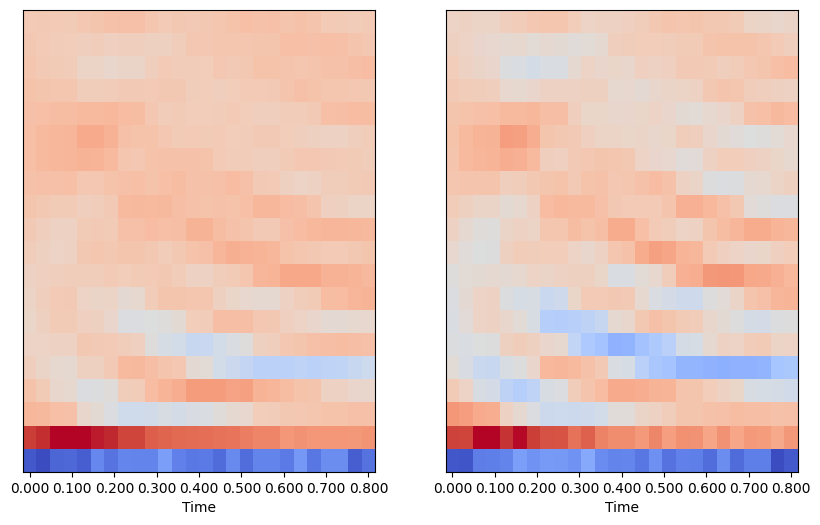

In [112]:
mp.figure(figsize=(10,6))
mp.subplot(121)
librosa.display.specshow(mfcc,x_axis='time',sr=fs)

data=two_tone
mfcc_f=librosa.feature.mfcc(y=data,sr=fs,n_mfcc=n_mfcc)

mp.subplot(122)
librosa.display.specshow(mfcc_f,x_axis='time',sr=fs)
mp.show()

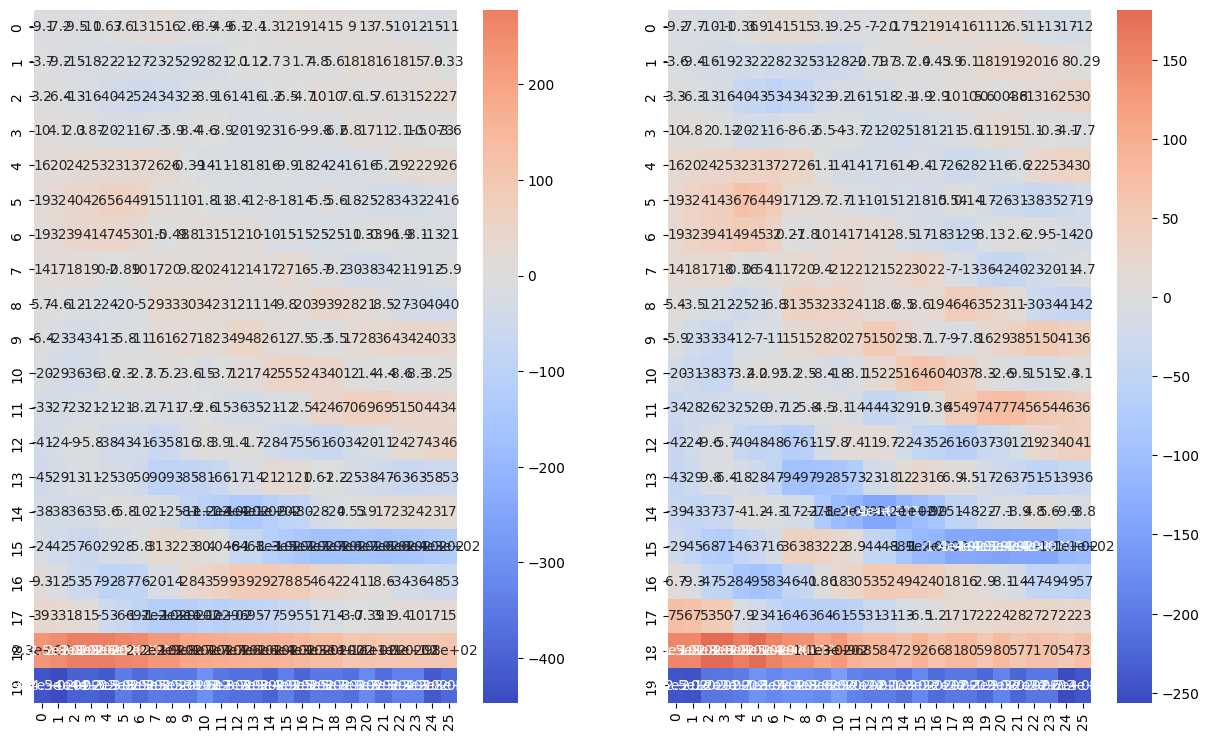

In [124]:
mp.figure(figsize=(15,9))
mp.subplot(121)
sns.heatmap(mfcc[::-1],center=0.,cmap='coolwarm',annot=True)
mfcc_f=librosa.feature.mfcc(y=data,sr=fs,n_mfcc=n_mfcc)

mp.subplot(122)
sns.heatmap(mfcc_f[::-1],center=0.,cmap='coolwarm',annot=True)
mp.show()

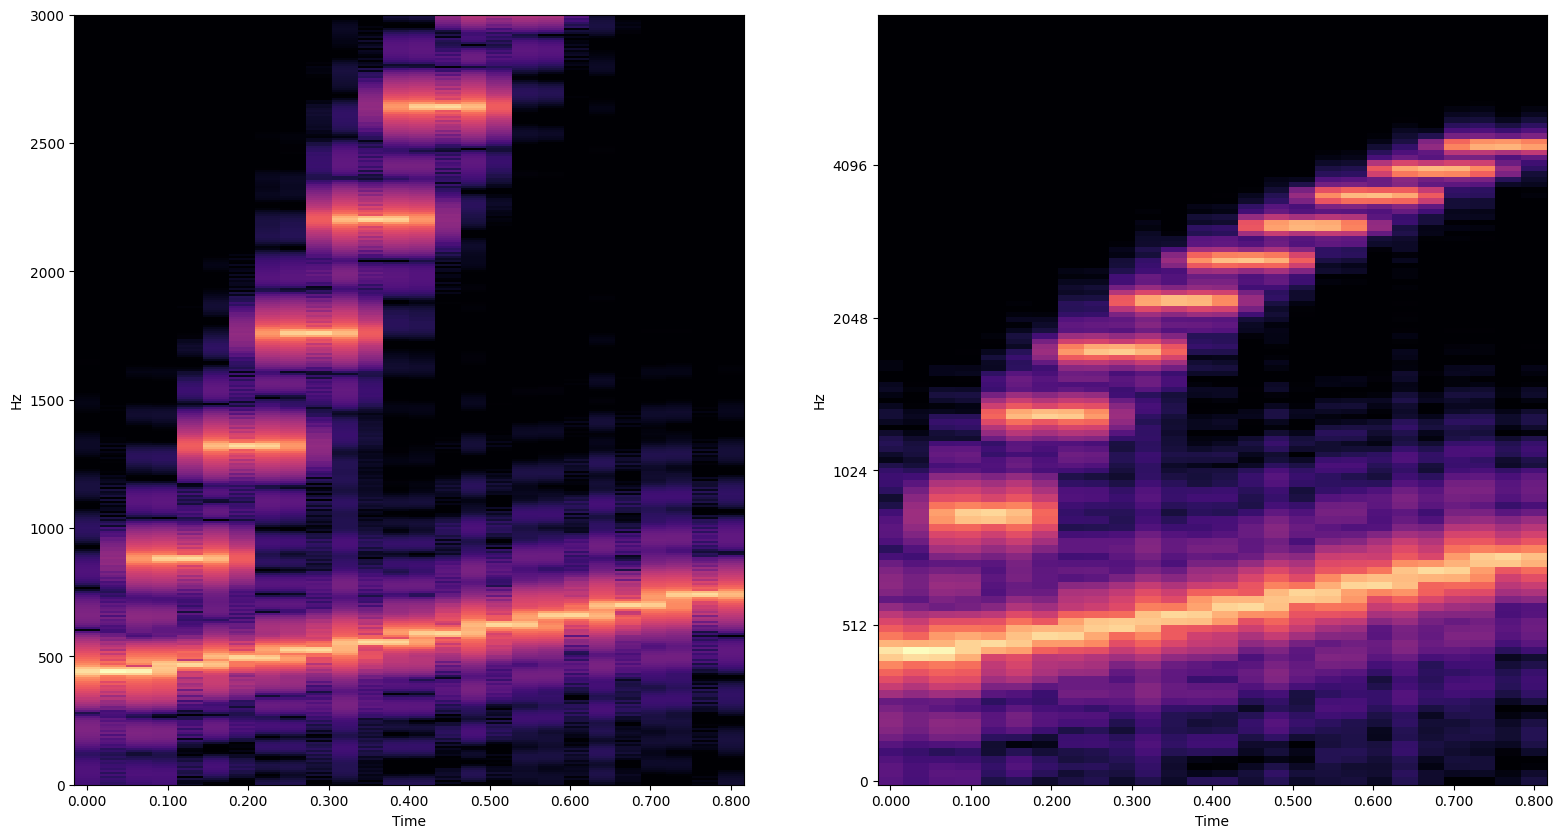

In [135]:
import librosa
import librosa.display
data=two_tone

mp.figure(figsize=(19,10))
mp.subplot(121)
d_stft=np.abs(librosa.stft(data))
librosa.display.specshow(librosa.amplitude_to_db(d_stft,ref=np.max),sr=fs,y_axis='linear',x_axis='time')
mp.ylim(0,3000)


mp.subplot(122)
d_msp=librosa.feature.melspectrogram(y=data,sr=fs,n_mels=128)
librosa.display.specshow(librosa.power_to_db(d_map,ref=np.max),sr=fs,y_axis='mel',x_axis='time')
mp.show()

#ref=np.max는 librosa.amplitude_to_db() 함수에서 진폭 스케일링 기준을 나타내는 인수입니다.
#이 인수가 np.max로 설정되면, STFT 데이터의 최대 진폭 값이 스케일링 기준이 됩니다.
#즉, STFT 데이터의 진폭이 최대 값으로 정규화됩니다.

# resample
librosa.resanple(y,orig_sr,target_sr,res_type='kaiser_best',fix=True,scale=False)

y: 원본 오디오 데이터 (ndarray)

orig_sr: 원본 오디오 데이터의 샘플링 주파수 (int)

target_sr: 목표 샘플링 주파수 (int)

res_type: resampling 필터 타입. 'kaiser_best' 또는 
'kaiser_fast' (str, default: 'kaiser_best')

fix: True인 경우, resampling 된 오디오 데이터 길이가 원래 길이와 같도록 맞춥니다. False인 경우, 길이가 다를 수 있습니다. (bool, default: True)

scale: True 인 경우, resampled 된 오디오 데이터의 크기를 조정합니다. False 인 경우, 크기가 그대로 유지됩니다. (bool, default: False)

res_type은 resampling 필터를 결정합니다. 'kaiser_best'와 'kaiser_fast'는 Kaiser-windowed sinc filter를 사용합니다. 'kaiser_best'는 더 높은 품질의 필터를 사용하므로 더 오래 걸립니다. 기본값은 'kaiser_best'입니다.


In [144]:
import librosa

y,sr=librosa.load('PRESERVED ROSES.wav',sr=44100)
y_resample=librosa.resample(y,sr,22050)


TypeError: resample() takes 1 positional argument but 3 were given

# effects.trim
오디오 신호에서 시작과 끝의 정적인 소음을 자르거나 제거하는 데 사용됩니다.

librosa.effects.trim(y, top_db=60, frame_length=2048, hop_length=512)

y: 오디오 신호 (1차원 배열 또는 시리즈).

top_db: 임계값(dB)으로, 이 값보다 작은 소음은 정적으로 간주되고 잘리게 됩니다. 기본값은 60dB입니다.

frame_length: 프레임 길이로, STFT(Short-Time Fourier Transform) 분석에 사용되는 프레임의 길이입니다. 기본값은 2048입니다.

hop_length: 프레임 간격으로, STFT 분석에서 프레임 사이의 간격을 결정하는 값입니다. 기본값은 512입니다.

In [149]:
import librosa
y,sr=librosa.load('PRESERVED ROSES.wav')
y_trim,index=librosa.effects.trim(y,top_db=30)
print("원본 신호 길이:", len(y))
print("잘린 신호 길이:", len(y_trim))

원본 신호 길이: 6739950
잘린 신호 길이: 6668800


# util.fix_length

주어진 배열을 주어진 길이로 고정합니다

librosa.util.fix_length(x, size=size, axis=-1,  **kwargs)

x: 원본 배열입니다. 고정할 배열입니다.

size: 고정할 길이를 지정하는 정수 값입니다. x 배열의 길이가 이 값보다 작은 경우, x 배열의 끝에는 0으로 채워진 부분이 추가됩니다. x 배열의 길이가 이 값보다 큰 경우, x 배열의 일부분이 잘려서 반환됩니다.

axis: 고정할 축(axis)을 지정합니다. 기본값은 -1로 마지막 축을 의미합니다. 예를 들어, axis=0으로 설정하면 첫 번째 축을 고정합니다.

kwargs: np.pad 함수에 전달할 추가 인수들입니다. 이 값들은 np.pad 함수에서 사용되는 **kwargs로 전달됩니다.

librosa.util.fix_length() 함수는 np.pad 함수를 사용하여 배열을 패딩합니다. 패딩 모드(mode)와 패딩하는 축(axis)을 지정할 수 있습니다. 기본적으로는 constant 모드를 사용하여 배열을 0으로 패딩합니다.

=============================================================
'constant' : 고정할 값을 상수로 지정
'edge' : 경계값으로 채움
'wrap' : 입력 배열을 wrapping하여 채움
'reflect' : 입력 배열을 reflecting하여 채움
'symmetric' : 입력 배열을 symmetrizing하여 채움

value: 배열을 고정할 때 사용할 값입니다. 기본값은 0입니다. 이 값은 np.pad 함수에서 사용되는 constant_values 인수로 전달됩니다.

np.pad() 함수에 전달할 추가 인수는 mode 인수가 'constant'인 경우, constant_values 인수를 이용하여 고정할 값을 지정할 수 있습니다. 예를 들어, mode='constant', constant_values=0으로 지정할 경우 입력 배열의 끝 부분에 0을 채워서 배열의 크기를 고정합니다.

In [150]:
import librosa
x = [1, 2, 3, 4, 5]
fix_x=librosa.util.fix_length(x,7)
print(fix_x)

TypeError: fix_length() takes 1 positional argument but 2 were given

# 파일 load
y, sr = librosa.core.load(path, sr=None, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')

librosa.core.load와 다르게 librosa.load는 추가적인 인자들을 **kwargs로 받습니다. 이를 이용해 추가적인 설정을 할 수 있습니다. 예를 들면, librosa.load 함수는 res_type을 더 다양한 방법으로 설정할 수 있습니다.

y, sr = librosa.load(path, sr=None, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best', **kwargs)


In [161]:
y, sr = librosa.load('PRESERVED ROSES.wav', sr=44100, mono=True, offset=0.1)
print(y.shape)
sr

(13475490,)


44100